# OVERVIEW

Classification is a method to build a model for classify the response variable from feature variable. In this classification case, We can see that data have imbalance dataset. Imbalance dataset means that response variable has different proportion of class. It will be affected if we when apply model for classification, the model will have tendency with majority class. With this situation we can't just see the accuracy for evaluate the model we must using other metrics value for evaluate our model.

The list of metrics we will be interesed are:
1. Specificity
2. Recall
3. F1_score
4. AUC
5. Log_loss
6. Geometric Mean (Sensitivity - Specificity)
7. Geometric Mean (Precision - Sensitivity)

After we choose the metrics, we must choose a method that can balancing target class. For the comparison we will use :
1. [Random Under Sampling](#cell1)
2. [SMOTE (Synthetic Minority Over-sampling Technique)](#cell2)
3. [Combination of Under and Over sampling (SMOTEENN)](#cell3)




source : https://www.analyticsvidhya.com/blog/2017/03/imbalanced-classification-problem/


# IMPORT LIBRARY

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# INPUT ALL DATASET

In [5]:
df_main = pd.read_csv('CLEAN DATASET.csv')
df_main = df_main.drop(['bank_id'],axis=1)
df_main = pd.get_dummies(df_main)

In [6]:
df_train = df_main[:26315]
df_test = df_main[26315:]

In [84]:
df_test.to_csv('UKUY.csv')

In [7]:
X = df_train.drop(['DELQ_FLG'],1)
y = df_train['DELQ_FLG']
X_test = df_test.drop(['DELQ_FLG'],1)

In [8]:
df_main['DELQ_FLG'].value_counts()

0.0    24187
1.0     2128
Name: DELQ_FLG, dtype: int64

In [9]:
df_main['DELQ_FLG'].value_counts(normalize = True)

0.0    0.919134
1.0    0.080866
Name: DELQ_FLG, dtype: float64

In [10]:
X = X.values
X_test = X_test.values

# MAKE MODELING FUNCTION

When we build this function we use some method :
1. Training and testing split
2. Stratified 10-Fold Cross Validation each method classification in training data
3. Balancing data when we build a model, but in validation fold is similar like original data
4. Evaluate every model

In [11]:
import pandas as pd
import numpy as np
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import make_scorer,accuracy_score,roc_auc_score,precision_score,recall_score,f1_score,log_loss

def geometric_mean_pres_rec(y_true,y_pred):
    score = precision_score(y_true,y_pred)*recall_score(y_true,y_pred)
    return(score)


def model_classification(verbose):
    # simple classification
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.naive_bayes import BernoulliNB
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.neural_network import MLPClassifier
    
    # hard classification
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    
    if verbose:
        print("Set Simple Model")
    logreg = LogisticRegression(random_state = 123)
    knn = KNeighborsClassifier()
    nb = BernoulliNB()
    dt = DecisionTreeClassifier(random_state = 123)
    
    if verbose:print("Set Hard Model\n")
    rf = RandomForestClassifier(random_state = 123)
    gbc = GradientBoostingClassifier(random_state = 123)
    xgb = XGBClassifier(random_state=123)
    
    model = [logreg,knn,nb,dt,rf,gbc,xgb]
    method_name = ['Logistic Regression',
                  'K-Nearest Neighbor',
                  'Naive Bayes',
                  'Decision Tree',
                  'Random Forest',
                  'Gradient Boosting Classifier',
                  'Extreme Gradient Boosting']
    return [model,method_name]
    
def pipe_imbalance(X,y,imb = RandomUnderSampler(),verbose = False):
    
    df_eval = pd.DataFrame(columns = ['Model',
                                    'Accuracy',
                                    'Precision',
                                    'Recall',
                                    'AUC',
                                    'F1_score',
                                    'Log_loss',
                                    'Geometric_Mean',
                                    'Geometric_Mean_Precision_Recall',
                                    'Time'])

    if verbose: print("Split Training and Testing\n")
    X_train, X_test,y_train,y_test = train_test_split(X,
                                                        y,
                                                        test_size = 0.3,
                                                        stratify = y,
                                                        random_state = 123)

    if verbose: print('Import Classification Method\n')
    
    list_model = model_classification(True)
    df_eval['Model']=list_model[1]

    if verbose: print('Building Pipeline\n')
    pipe = Pipeline([('imb',imb),('classifier',LogisticRegression())])

    if verbose: print('Defining Params and Scoring\n')
    params = {'classifier': list_model[0]}
    scorers = {'accuracy':make_scorer(accuracy_score),
               'precision':make_scorer(precision_score),
               'recall':make_scorer(recall_score),
               'roc_auc':make_scorer(roc_auc_score),
               'f1':make_scorer(f1_score),
               'neg_log_loss':'neg_log_loss',
               'gm':make_scorer(geometric_mean_score),
               'gmpr':make_scorer(geometric_mean_pres_rec)}
    
    skf = StratifiedKFold(n_splits=10,random_state = 123)
    
    grid = GridSearchCV(estimator = pipe,
                    param_grid = params,
                    scoring = scorers,
                    refit = 'accuracy',
                    cv = skf)
    grid.fit(X_train,y_train)
    
    df_eval['Accuracy']  = grid.cv_results_['mean_test_accuracy']
    df_eval['Precision'] = grid.cv_results_['mean_test_precision']
    df_eval['Recall'] = grid.cv_results_['mean_test_recall']
    df_eval['AUC'] = grid.cv_results_['mean_test_roc_auc']
    df_eval['F1_score'] = grid.cv_results_['mean_test_f1']
    df_eval['Log_loss'] = grid.cv_results_['mean_test_neg_log_loss']
    df_eval['Geometric_Mean'] = grid.cv_results_['mean_test_gm']
    df_eval['Geometric_Mean_Precision_Recall'] = grid.cv_results_['mean_test_gmpr']
    df_eval['Time'] = grid.cv_results_['mean_fit_time']
    
    return [grid,df_eval,X_test,y_test]


# <a id='cell1'></a>USING RANDOM UNDERSAMPLING

In [12]:
df_under = pipe_imbalance(X,y, verbose=True)

Split Training and Testing

Import Classification Method

Set Simple Model
Set Hard Model

Building Pipeline

Defining Params and Scoring



In [22]:
df_under[1]

,Model,Accuracy,Precision,Recall,AUC,F1_score,Log_loss,Geometric_Mean,Geometric_Mean_Precision_Recall,Time
0,Logistic Regression,0.574267,0.132995,0.772483,0.664653,0.226899,-0.621642,0.655578,0.102810,0.587736
1,K-Nearest Neighbor,0.517535,0.092593,0.564430,0.538919,0.159074,-2.148959,0.537761,0.052531,0.074082
2,Naive Bayes,0.509446,0.112474,0.734899,0.612252,0.195088,-1.381179,0.599711,0.082803,0.079778
3,Decision Tree,0.597231,0.116989,0.607383,0.601860,0.196167,-13.911139,0.601550,0.071253,0.119525
4,Random Forest,0.667698,0.132334,0.559060,0.618160,0.213960,-0.952678,0.615044,0.074078,0.121792
5,Gradient Boosting Classifier,0.574756,0.136024,0.794631,0.675018,0.232249,-0.604204,0.664071,0.108224,1.589149
6,Extreme Gradient Boosting,0.559175,0.132765,0.804027,0.670826,0.227870,-0.604395,0.657220,0.106788,1.685711


# <a id='cell2'></a>USING SMOTE

In [ ]:
df_smote = pipe_imbalance(X,y,imb=SMOTE(k_neighbors=11), verbose=True)

Split Training and Testing

Import Classification Method

Set Simple Model
Set Hard Model

Building Pipeline

Defining Params and Scoring



In [94]:
df_smote[1]

,Model,Accuracy,Precision,Recall,AUC,F1_score,Log_loss,Geometric_Mean,Geometric_Mean_Precision_Recall,Time
0,Logistic Regression,0.587242,0.126511,0.693960,0.635905,0.213978,-0.620272,0.632697,0.088401,3.765997
1,K-Nearest Neighbor,0.638165,0.094800,0.406711,0.532623,0.153723,-3.521287,0.516541,0.038981,1.166332
2,Naive Bayes,0.710912,0.120634,0.409396,0.573422,0.186218,-0.546642,0.548300,0.049819,0.316043
3,Decision Tree,0.850109,0.133675,0.155705,0.533464,0.143792,-5.177132,0.374507,0.021767,0.803787
4,Random Forest,0.915581,0.260381,0.020805,0.507567,0.038279,-0.986547,0.141937,0.005958,0.660046
5,Gradient Boosting Classifier,0.918893,0.000000,0.000000,0.499882,0.000000,-0.266021,0.000000,0.000000,19.848024
6,Extreme Gradient Boosting,0.919110,0.000000,0.000000,0.500000,0.000000,-0.263879,0.000000,0.000000,14.479818


# <a id='cell3'></a>USING SMOTEENN

In [96]:
df_smoteenn = pipe_imbalance(X,y,imb=SMOTEENN(), verbose=True)

Split Training and Testing

Import Classification Method

Set Simple Model
Set Hard Model

Building Pipeline

Defining Params and Scoring



In [97]:
df_smoteenn[1]

,Model,Accuracy,Precision,Recall,AUC,F1_score,Log_loss,Geometric_Mean,Geometric_Mean_Precision_Recall,Time
0,Logistic Regression,0.477742,0.119612,0.857047,0.650703,0.209907,-0.756342,0.616965,0.102526,33.199417
1,K-Nearest Neighbor,0.563409,0.090877,0.488591,0.529292,0.153244,-9.166988,0.527316,0.044636,32.870485
2,Naive Bayes,0.511618,0.115730,0.757718,0.623838,0.200748,-0.905964,0.608835,0.087810,32.850071
3,Decision Tree,0.815147,0.135463,0.238255,0.552087,0.172593,-6.384709,0.453674,0.032524,32.099859
4,Random Forest,0.903855,0.209250,0.065772,0.521693,0.099932,-0.702195,0.251669,0.014725,32.572409
5,Gradient Boosting Classifier,0.903963,0.209846,0.067785,0.522670,0.102213,-0.301254,0.255371,0.014971,41.679651
6,Extreme Gradient Boosting,0.904289,0.220122,0.071812,0.524683,0.108000,-0.299005,0.261523,0.017196,45.580720


# LAST EVALUATION USING TRAINING AND TESTING DATA

In [112]:
%%time
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state =123)
rus = RandomUnderSampler()
X_sampled,y_sampled = rus.fit_resample(X_train,y_train)
xgb = XGBClassifier()
xgb.fit(X_sampled,y_sampled)

Wall time: 2.36 s


In [113]:
y_prob = xgb.predict_proba(X_test)

In [114]:
from sklearn.metrics import roc_curve

def plot_roc_curve(ytest, P_ensemble):
    """Plot the roc curve for base learners and ensemble."""
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--')

    fpr, tpr, _ = roc_curve(y_test, P_ensemble)
    plt.plot(fpr, tpr)
        
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.show()


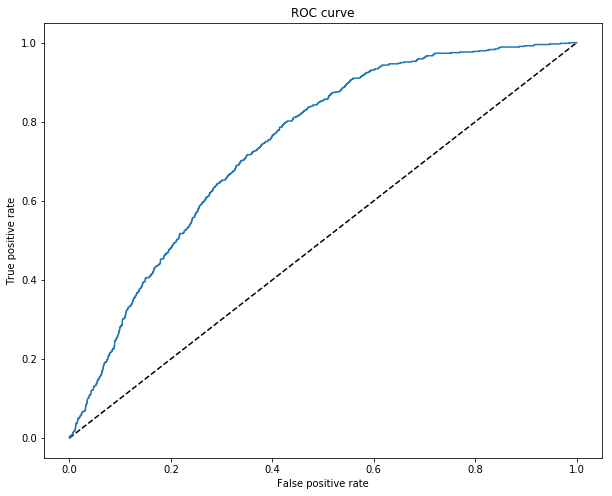

In [115]:
plot_roc_curve(y_test,y_prob[:,1])

In [120]:
y_pred = xgb.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.56      0.71      7259
         1.0       0.14      0.81      0.24       636

   micro avg       0.58      0.58      0.58      7895
   macro avg       0.55      0.68      0.47      7895
weighted avg       0.90      0.58      0.67      7895



# BUSINESS PROBLEM

In [151]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test,y_pred))

,0,1
0,4042,3217
1,120,516


## DELINQUENCY RATE

In [154]:
DR_now = y_test.value_counts(normalize=True)[1]*100

In [155]:
DR_after = 516*100/len(y_test)

In [156]:
DR_after-DR_now

-1.519949335022166

Delinquency Rate from 8.056% to 6.536%. We can reduce 1.52%

## POTENTIAL REVENUE LOSS

Potential revenue loss is percentage wrong classified delinquent customer from all customer 

In [158]:
RL = 120/len(y_test)
RL*100

1.5199493350221658

So the potential revenue loss is 1.52%

# TOP 20 FEATURE IMPORTANCES

In [121]:
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]

In [125]:
to_bar = pd.DataFrame([df_main.drop(['DELQ_FLG'],1).columns[indices],importances[indices]]).transpose()
to_bar.columns = ['Feature','Value']

Feature ranking:
1. feature loan_application_day (0.154589)
2. feature AGE (0.123994)
3. feature SA_AVG_BAL (0.090177)
4. feature CC_CNT (0.048309)
5. feature CNT_MOBILE_PHONE (0.032206)
6. feature INS_CNT (0.028986)
7. feature POSTPAID_TXN_CNT_TOTAL_TELCO (0.020934)
8. feature MARITAL_STATUS_Single (0.020934)
9. feature PREPAID_AMT_MTH_6 (0.020934)
10. feature INS_LIFE_CNT (0.020934)
11. feature STATE_Johor Darul Takzim (0.017713)
12. feature OCC_DESC_NON-EXECUTIVE (0.017713)
13. feature OCC_DESC_SELF EMPLOYED (0.016103)
14. feature OCC_DESC_OTHERS (0.016103)
15. feature PREPAID_CNT_MTH_5 (0.016103)
16. feature samsung (0.014493)
17. feature OCC_DESC_CEO/DIRECTOR (0.014493)
18. feature MOBILE (0.012882)
19. feature PREPAID_TXN_AMT_TOTAL_TELCO (0.012882)
20. feature OCC_DESC_MANAGER OR SUPERVISOR (0.012882)


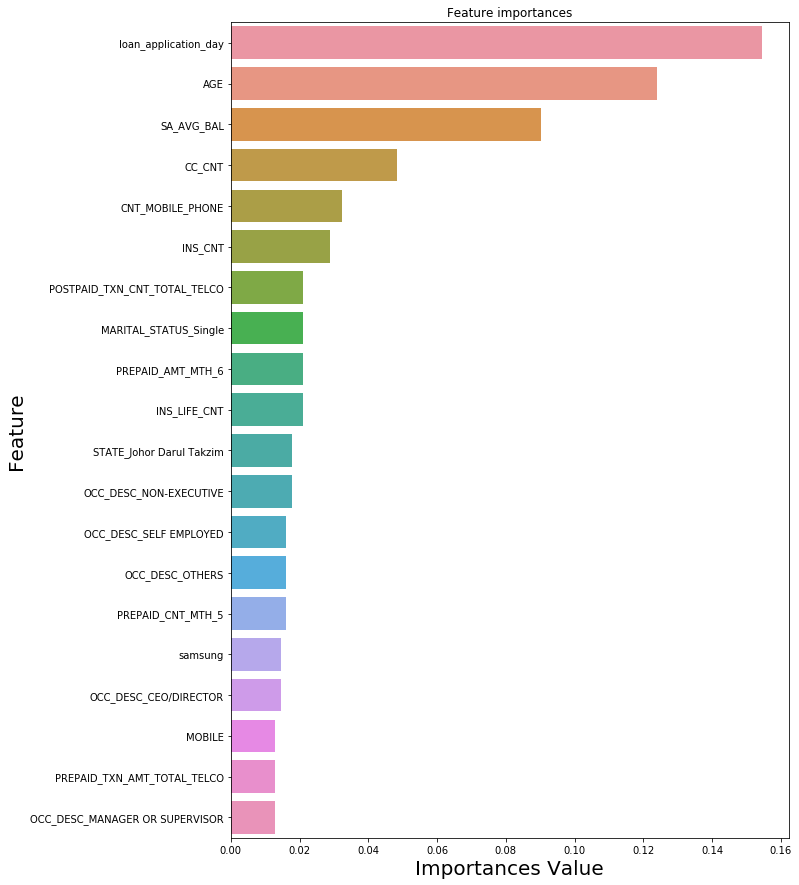

In [135]:
# Print the feature ranking
print("Feature ranking:")

for f in range(20):
    print("%d. feature %s (%f)" % (f + 1, df_main.drop(['DELQ_FLG'],1).columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(10, 15))
plt.title("Feature importances")
ax = sns.barplot(x='Value',y='Feature',data=to_bar[0:20])
plt.xlabel('Importances Value', fontsize = 20)
plt.ylabel('Feature', fontsize = 20)
plt.show()


# PREDICTION

In [47]:
%time
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state = 123)
X_resampled,y_resampled = rus.fit_resample(X,y)
xgb = XGBClassifier()
xgb.fit(X_resampled,y_resampled)


Wall time: 0 ns


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [48]:
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)

In [53]:
predik = pd.DataFrame({'DELQ_FLG':y_pred,
         'MODEL_SCORE':y_prob[:,1]}) 

In [54]:
predik.to_csv('Hasil Predik.csv')